# Training a Jet Tagging with **Conv2D** 

---
In this notebook, we perform a Jet identification task using a Conv2D multiclass classifier.
The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet image, i.e., a 2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100
bins of a square window of the ($\eta$, $\phi$) plane, centered along the jet axis.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

For details on the dataset, see Notebook1

---

In [4]:
import os
import h5py
import glob, pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

**nb, if you are running locally and you have already downloaded the datasets you can skip the cell below and, if needed, change the paths later to point to the folder with your previous download of the datasets.**

In [5]:
! curl https://cernbox.cern.ch/s/6Ec5pGFEpFWeH6S/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz 
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  16.9M      0 --:--:--  0:00:19 --:--:-- 23.3M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [6]:
target = np.array([])
jetImage = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locally, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myjetImage = np.array(f.get("jetImage"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetImage = np.concatenate([jetImage, myjetImage], axis=0) if jetImage.size else myjetImage
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, jetImage.shape)

Appending Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 100)


The dataset consists of 50000 with up to 100 particles in each jet. These 100 particles have been used to fill the 100x100 jet images.

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetImage, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetImage, target

(33500, 100, 100) (16500, 100, 100) (33500, 5) (16500, 5)


In keras, images are representable as $n \times m \times k$ tensors, where $n \times m$ are the pixel dimenions and $k$ is the number of channels (e.g., 1 in a black\&while image, 3 for an RGB image). In our case, k=1. To comply to this, we add the channel index by reshaping the image dataset.

Each pixel as a number in it, the 'color', so we have a 3D sample... But tensor flow does not interpretate like this, so we have to re-chape it. 

In [8]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(33500, 100, 100, 1) (16500, 100, 100, 1) (33500, 5) (16500, 5)


# Conv 2D model building

The main ingredients of a Conv2D layer are:

- **filter**: a *k x k’* matrix of weights (orange matrix in the picture below) that scans the image and performs a scalar product of each image block (this is also called *kernel*)
- **stride**: number of pixels the filter is shifted by (=1 in the image below)
- **padding**: the amount of pixels added to an image when it is being processed by the filter of a CNN (helps keeping information on the boundaries of the original image by allowing border pixels to be at the center of the filter)
    - *valid* means no padding (default setting)
    - *same* results in padding with zeros evenly to the left/right or up/down of the input image as needed to ensure that the output has the same shape as the input

<div>
<img src="https://raw.githubusercontent.com/jngadiub/ML_course_Pavia_23/main/neural-networks/conv2d.gif" width="400"/>
</div>

It is common practice to insert **pooling** layers in between Conv2D layers to progressively reduce the size of the representation and thus reduce the amount of parameters and computation in the network. Pooling also makes processing more robust to changes in the position of a feature in the image. Common types of pooling operations are:

- **MaxPooling**: given an image and a pool of size *k x k’*, scans the image and replaces each *k x k’* patch with its *maximum* -- helps to extract the sharpest features on the image when the sharpest features are a best lower-level representation of the image
- **AveragePooling**: given an image and a pool of size *k x k’*, scans the image and replaces each *k x k’* patch with its *average* -- helps to extract the smooth features when "colours" transition is smooth

<img src="https://github.com/jngadiub/ML_course_Pavia_23/blob/main/neural-networks/figures/pooling.png?raw=1" alt="Drawing" style="width: 800px;"/>

In [9]:
# keras imports
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import Dense, Input, Conv2D, Dropout, Flatten
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [10]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
dropoutRate = 0.25

In [11]:
image_shape = (img_rows, img_cols, 1)
####
inputImage = Input(shape=(image_shape))
x = Conv2D(5, kernel_size=(5,5), data_format="channels_last", strides=(1, 1), padding="same")(inputImage)
# 5 = nb of filters, strides (1,1) means that in all direction we stride
x = BatchNormalization()(x) #you normalize everything to the same shape
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (5,5))(x) #when you don't specify the stride, it does it in the full dimensions
x = Dropout(dropoutRate)(x) #dropout randomly choose a nb of parameters to be zero to prevent overfitting
#
x = Conv2D(3, kernel_size=(3,3), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (3,3))(x)
x = Dropout(dropoutRate)(x)
#
x = Flatten()(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputImage, outputs=output)

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 5)       130       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 5)      20        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 100, 100, 5)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 5)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 20, 5)         0     

We now train the model. This takes really long time and processing power on common CPUs. **If you are running locally set TRAIN=False** such that a pre-trained model is loaded for the next evaluation steps. We live as homework to reproduce the results (suggest to use Colab with GPU).

In [20]:
TRAIN = False
batch_size = 128
n_epochs = 1 #max

if TRAIN: #train and save the model
    
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                        validation_data=(X_val, y_val),
                        callbacks = [
                        EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                        TerminateOnNaN()])

    model_json = model.to_json()
    !mkdir jetTagger_CNN
    outputdir = './jetTagger_CNN/'
    # to avoid to train each time, you save it in a Jason format, and than you put train to Faulse, it contains the architecture (nb filters, the optimizer..)

    with open("{OUTPUTDIR}/jetTagger_CNN.json".format(OUTPUTDIR=outputdir), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("{OUTPUTDIR}/jetTagger_CNN.h5".format(OUTPUTDIR=outputdir))
    #then , you have also to save the weights, in another file

    with open('{OUTPUTDIR}/history.h5'.format(OUTPUTDIR=outputdir), 'wb') as f:
      pickle.dump(history.history, f, protocol=pickle.HIGHEST_PROTOCOL)    
    
else: #load pretrained model
    
    ! curl https://cernbox.cern.ch/index.php/s/yYUgxxSnYN42qay/download -o jetTagger_CNN.tar.gz
    ! tar -xvzf jetTagger_CNN.tar.gz 
    ! ls jetTagger_CNN/
    ! rm jetTagger_CNN.tar.gz
    
    with open('jetTagger_CNN/jetTagger_CNN.json', 'r') as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json)
    model.load_weights("jetTagger_CNN/jetTagger_CNN.h5")
    
    with open('jetTagger_CNN/history.h5', 'rb') as f: history = pickle.load(f)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   169  100   169    0     0    225      0 --:--:-- --:--:-- --:--:--   224

gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now
history.h5  jetTagger_CNN.h5  jetTagger_CNN.json


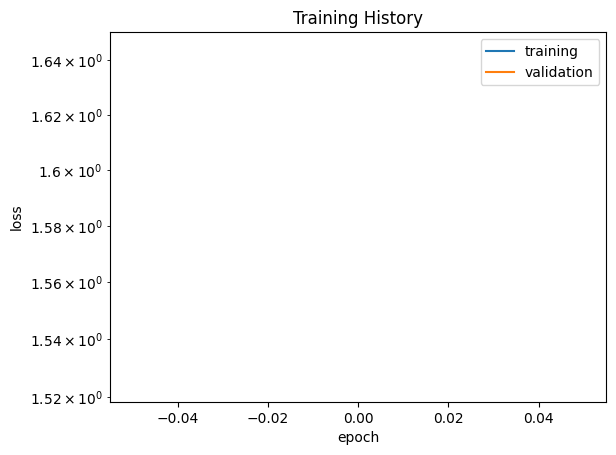

In [21]:
# plot training history
import pandas as pd
if TRAIN: history = pd.DataFrame(history.history)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Building the ROC Curves

In [16]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

516/516 [==============================] - 2s 4ms/step


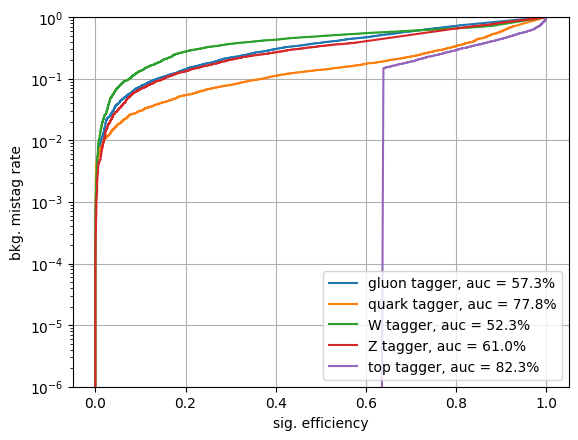

In [17]:
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()